# Improving Deep Neural Networks: Hyperparameter Tuning, Regularization and Optimization

<a name='1'></a>
## 1 - Packages

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import math
from reg_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

<a name='3'></a>
## 2 - The Dataset

Here we are going to use a deep learning model to find the positions on the field where the goalkeeper of a Football team should kick the ball.

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

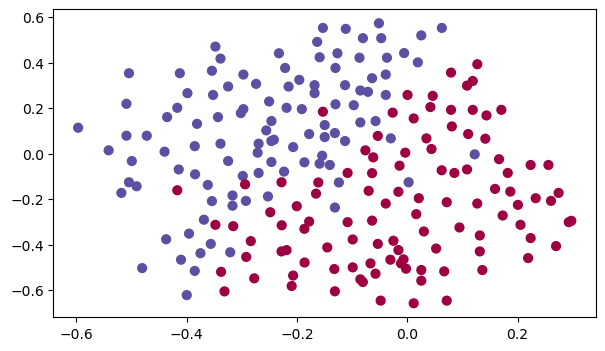

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

<a name='4'></a>
## 3 - Model

In [3]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1, initialization = "xe"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
    grads = {}
    costs = []                            # to keep track of the cost
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    if initialization == "xe":
        parameters = initialize_parameters(layers_dims)
    elif initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            Al, cache = L_model_forward(X, parameters)
        elif keep_prob < 1:
            Al, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(Al, Y)
        else:
            cost = compute_cost_with_regularization(Al, Y, parameters, lambd)
            
        # Backward propagation.
        assert (lambd == 0 or keep_prob == 1)   
                                                
        if lambd == 0 and keep_prob == 1:
            grads = L_model_backward(Al, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(Al, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(Al, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
    
    # plot the cost
    costs = np.squeeze(costs)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 4 - Initialization

Training a neural network requires specifying an initial value of the weights. A well-chosen initialization method helps the learning process. There are two types of parameters to initialize in a neural network:

- the weight matrices $(W^{[1]}, W^{[2]}, W^{[3]}, ..., W^{[L-1]}, W^{[L]})$
- the bias vectors $(b^{[1]}, b^{[2]}, b^{[3]}, ..., b^{[L-1]}, b^{[L]})$

### 4.1 initialize_parameters_zeros

Let's train the model with  all parameters initialize to zeros.

In [4]:
def initialize_parameters_zeros(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))  

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

Cost after iteration 0: 0.6931471805599453
Cost after iteration 10000: 0.6931359498627058
Cost after iteration 20000: 0.6931359498627058


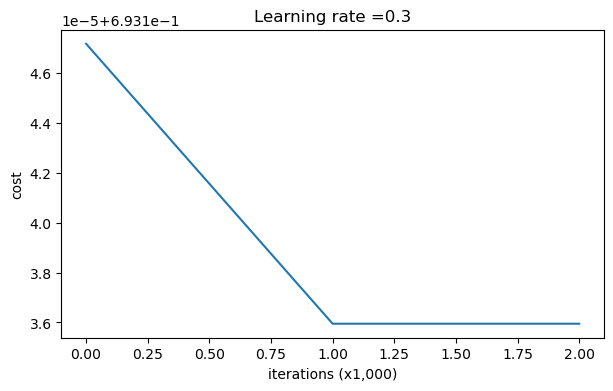

On the train set:
Accuracy: 50%
On the test set:
Accuracy: 43%


In [5]:
parameters = model(train_X, train_Y, initialization = "zeros")
print ("On the train set:")
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')
print ("On the test set:")
predictions_test = predict(parameters, test_X)
print ('Accuracy: %d' % float((np.dot(test_Y, predictions_test.T) + np.dot(1 - test_Y, 1 - predictions_test.T)) / float(test_Y.size) * 100) + '%')

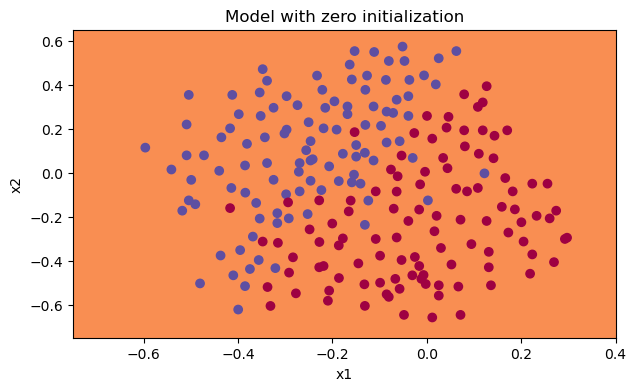

In [6]:
plt.title("Model with zero initialization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

The performance is terrible, the cost doesn't decrease significantly, and the algorithm performs no better than random guessing. In general, initializing all the weights to zero results in the network failing to break symmetry. This means that every neuron in each layer will learn the same thing, so you might as well be training a neural network with  $n^{[l]}=1$ for every layer. This way, the network is no more powerful than a linear classifier like logistic regression.

### 4.2 Random Initialization

To break symmetry, it is neccesary to initialize the weights randomly. Following random initialization, each neuron can then proceed to learn a different function of its inputs.

In [7]:
def initialize_parameters_random(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)               # This seed makes sure your "random" numbers will be the as ours
    parameters = {}
    L = len(layers_dims)            # integer representing the number of layers
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))  

    return parameters

Cost after iteration 0: 0.6931467291600245
Cost after iteration 10000: 0.22985448105095577
Cost after iteration 20000: 0.22972826610936384


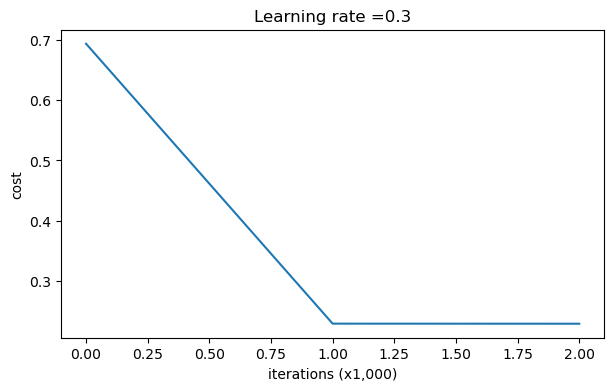

On the train set:
Accuracy: 91%
On the test set:
Accuracy: 92%


In [8]:
parameters = model(train_X, train_Y, initialization = "random")
print ("On the train set:")
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')
print ("On the test set:")
predictions_test = predict(parameters, test_X)
print ('Accuracy: %d' % float((np.dot(test_Y, predictions_test.T) + np.dot(1 - test_Y, 1 - predictions_test.T)) / float(test_Y.size) * 100) + '%')

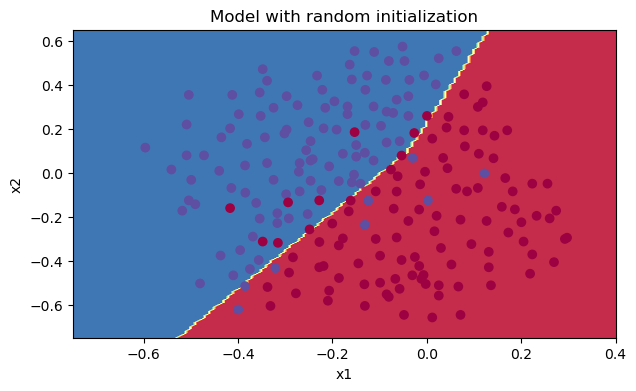

In [9]:
plt.title("Model with random initialization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

We've now broken the symmetry, and this gives noticeably better accuracy than before.

### 4.3 He Initialization

This is named for the first author of He et al., 2015. (where a scaling factor for the weights $W^{[l]}$ of `sqrt(2./layers_dims[l-1])` would use.)

In [10]:
def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2./layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))  

        
    return parameters

Cost after iteration 0: 0.6060964880245826
Cost after iteration 10000: 0.16152624778469843
Cost after iteration 20000: 0.143016661945888


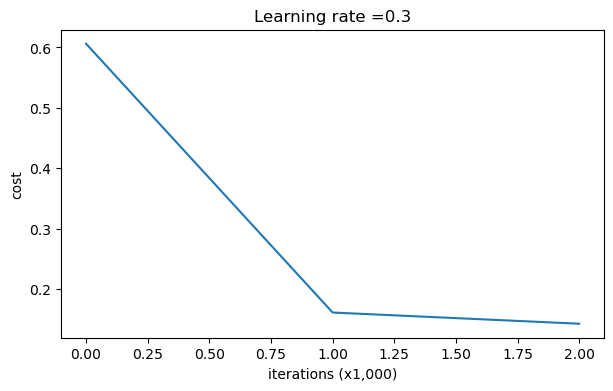

On the train set:
Accuracy: 94%
On the test set:
Accuracy: 94%


In [11]:
parameters = model(train_X, train_Y, initialization = "he")
print ("On the train set:")
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')
print ("On the test set:")
predictions_test = predict(parameters, test_X)
print ('Accuracy: %d' % float((np.dot(test_Y, predictions_test.T) + np.dot(1 - test_Y, 1 - predictions_test.T)) / float(test_Y.size) * 100) + '%')

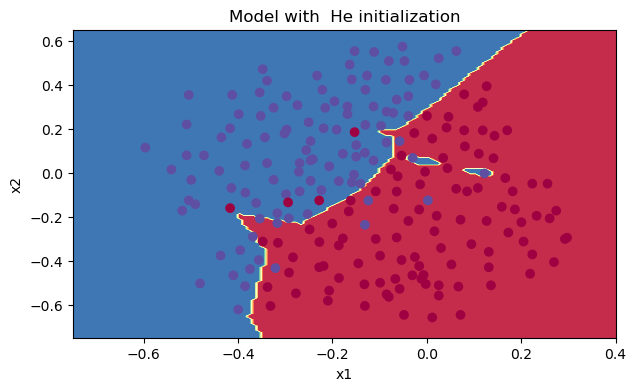

In [12]:
plt.title("Model with  He initialization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

The model with He initialization separates the blue and the red dots very well in a small number of iterations.

## 5 - Regularization

The previous model were non-regularized models. The non-regularized models are obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

<a name='5'></a>
### 5.1 - L2 Regularization

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes.  It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [13]:
def compute_cost_with_regularization(Al, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    Al -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    L = len(parameters) // 2 # number of layers in the neural network
    
    cross_entropy_cost = compute_cost(Al, Y) # This gives you the cross-entropy part of the cost
    
    # L2_regularization_cost 
    L2_regularization_cost = 0
    for l in range(L):
        L2_regularization_cost += 1/m*lambd/2*(np.sum(np.square(parameters["W" + str(l+1)]))) 
         
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

Of course, because we changed the cost, we have to change backward propagation as well! All the gradients have to be computed with respect to this new cost. 


In [14]:
def backward_propagation_with_regularization(AL, Y, caches, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    Al -- probability vector, output of the forward propagation 
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    def linear_backward(dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.dot(dZ,A_prev.T) + lambd/m*W #add regularization term
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)

        return dA_prev, dW, db

    def linear_activation_backward(dA, cache, activation):
        linear_cache, activation_cache = cache
        
        if activation == "relu":
            dZ = relu_backward(dA, activation_cache)
            dA_prev, dW, db = linear_backward(dZ, linear_cache)
            
        elif activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = linear_backward(dZ, linear_cache)
            
        else:
            print("\033[91mError! Please make sure you have passed the value correctly in the \"activation\" parameter")
        
        return dA_prev, dW, db
 
    gradients = {}
    L = len(caches) # the number of layers
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    gradients["dA" + str(L-1)], gradients["dW" + str(L)], gradients["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(gradients["dA" + str(l + 1)], current_cache, activation = "relu") 
        gradients["dA" + str(l)] = dA_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp 
        gradients["db" + str(l + 1)] = db_temp

    return gradients

Let's now run the model with L2 regularization $(\lambda = 0.7)$. 

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.26809163371273004


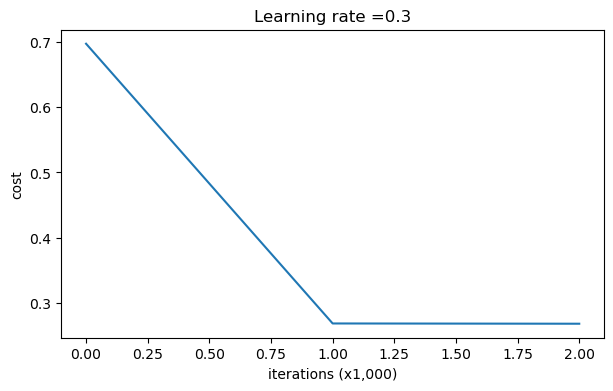

On the train set:
Accuracy: 93%
On the test set:
Accuracy: 93%


In [15]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')
print ("On the test set:")
predictions_test = predict(parameters, test_X)
print ('Accuracy: %d' % float((np.dot(test_Y, predictions_test.T) + np.dot(1 - test_Y, 1 - predictions_test.T)) / float(test_Y.size) * 100) + '%')

The test set accuracy increased to 93%. We are not overfitting the training data anymore. Let's plot the decision boundary.

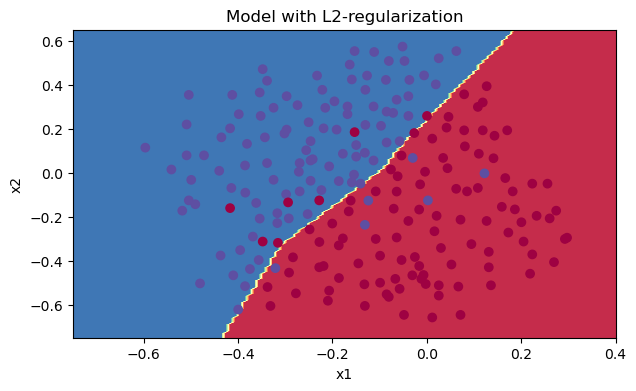

In [16]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

Note that regularization hurts training set performance! This is because it limits the ability of the network to overfit to the training set. But since it ultimately gives better test accuracy, it is helping our system. 

<a name='6'></a>
### 5.2 - Dropout

**Dropout** is a widely used regularization technique that is specific to deep learning. **It randomly shuts down some neurons in each iteration.** The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration.

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>



When we shut some neurons down, we actually modify our model. The idea behind drop-out is that at each iteration, we train a different model that uses only a subset of our neurons. With dropout, our neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.

**Note:** When using dropout, its is neceesary to divide the final output neuron by `keep_prob`. By doing this it is assure that the result of the cost will still have the same expected value as without drop-out- This technique is also called inverted dropout.

## 6 - Optimization Methods

Until now, we've always used Gradient Descent to update the parameters and minimize the cost. Nowe we are going to use some more advanced optimization methods that can speed up learning and perhaps even get a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result. 

We are going to use another dataset for this cases.

In [17]:
import sklearn.datasets
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral)
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

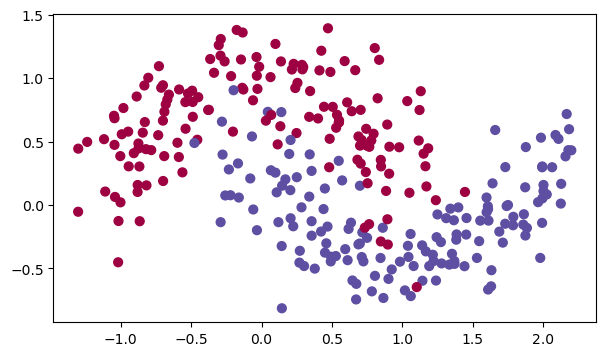

In [18]:
train_X, train_Y = load_dataset()

### 6.1 - Mini-Batch Gradient Descent

A variant of GD is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent, where each mini-batch has just 1 example. What changes is that we would be computing gradients on just one training example at a time, rather than on the whole training set.

There are two steps to implement mini batches:

- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

<center><img src="images/kiank_shuffle.png" style="width:550px;height:300px;"></center>

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

<center><img src="images/kiank_partition.png" style="width:550px;height:300px;"></center>


In [19]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    np.random.seed(seed)            
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:k*mini_batch_size+mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:k*mini_batch_size+mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Let's implement a model that work for the differents optimizers that we are going to implement.

In [20]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    grads = {}           
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    m = X.shape[1]                   # number of training examples
    seed = 10                       
    
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            Al, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost and add to the cost total - we'll first accumulate costs over an entire epoch and then divide by the m training examples
            def compute_cost(Al, Y):

                logprobs = np.multiply(-np.log(Al),Y) + np.multiply(-np.log(1 - Al), 1 - Y)
                cost_total =  np.sum(logprobs)
                
                return cost_total
            
            cost_total += compute_cost(Al, minibatch_Y)

            # Backward propagation
            grads = L_model_backward(Al, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Now lets run the model for Mini-Batch Gradient Descent

Cost after epoch 0: 0.695617
Cost after epoch 1000: 0.681671
Cost after epoch 2000: 0.664111
Cost after epoch 3000: 0.640501
Cost after epoch 4000: 0.606355


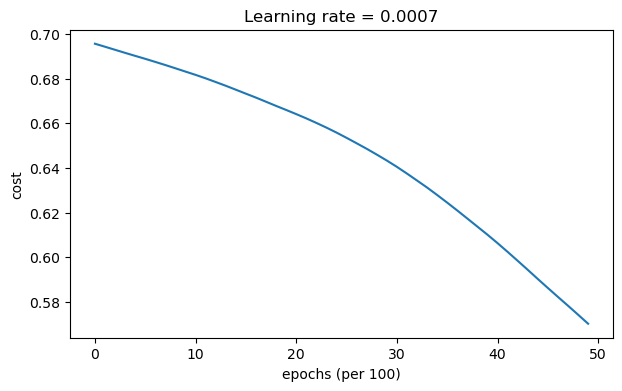

Accuracy: 71%


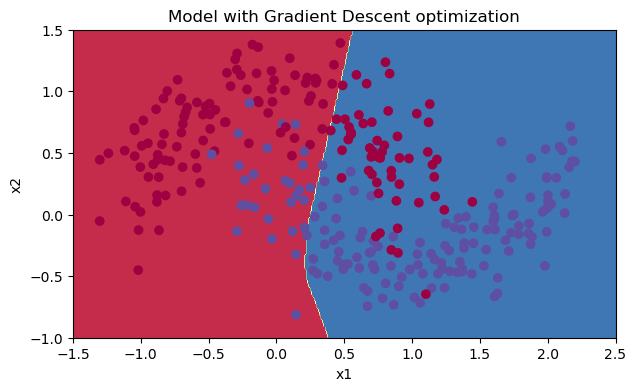

In [21]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

<a name='4'></a>
### 6.2 - Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. The 'direction' of the previous gradients is stored in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. We can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. 

The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate.

**How do $\beta$ is choosen?**

- The larger the momentum $\beta$ is, the smoother the update, because it takes the past gradients into account more. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for the model might require trying several values to see what works best in terms of reducing the value of the cost function $J$. 



In [22]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        
    return v

In [23]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(1, L + 1):
        
        v["dW" + str(l)] = beta*v["dW" + str(l)]+(1-beta)*grads["dW" + str(l)]
        v["db" + str(l)] = beta*v["db" + str(l)]+(1-beta)*grads["db" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)]-learning_rate*v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)]-learning_rate*v["db" + str(l)]
        
    return parameters, v

Now lets see how the model does with momentum

Cost after epoch 0: 0.695618
Cost after epoch 1000: 0.681702
Cost after epoch 2000: 0.664162
Cost after epoch 3000: 0.640605
Cost after epoch 4000: 0.606525


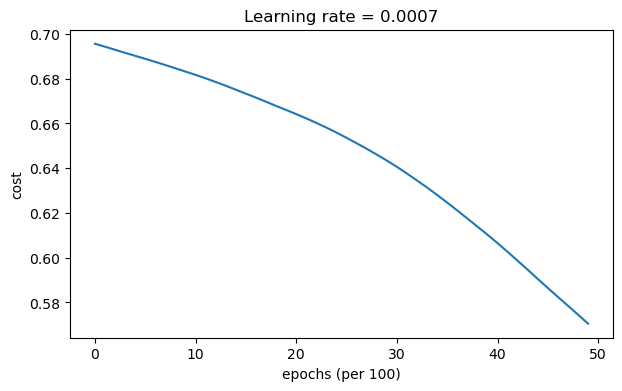

Accuracy: 71%


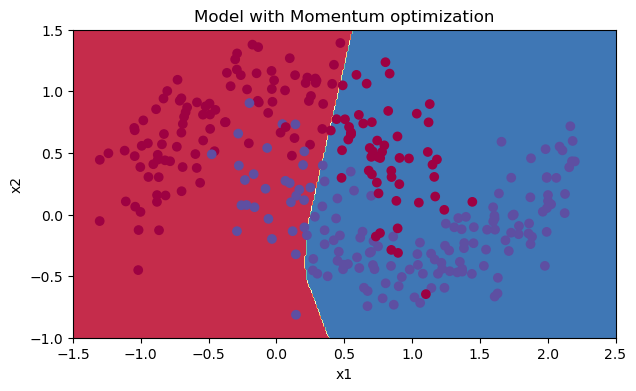

In [24]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

Because this example is relatively simple, the gains from using momemtum are small - but for more complex problems we might see bigger gains.

### 6.3 - Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

Some advantages of Adam include:

- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

In [25]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
    
    return v, s

In [26]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1-beta1)*grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1-beta1)*grads['db' + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1-beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1-beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1-beta2)*(grads['dW' + str(l)]**2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1-beta2)*(grads['db' + str(l)]**2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1-(beta2**t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1-(beta2**t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * (v_corrected["dW" + str(l)]/(np.sqrt(s_corrected["dW" + str(l)]) + epsilon)) 
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * (v_corrected["db" + str(l)]/(np.sqrt(s_corrected["db" + str(l)]) + epsilon))       

    return parameters, v, s, v_corrected, s_corrected

Finally, lets see how the model does with Adam.

Cost after epoch 0: 0.695455
Cost after epoch 1000: 0.166284
Cost after epoch 2000: 0.140135
Cost after epoch 3000: 0.135341
Cost after epoch 4000: 0.132502


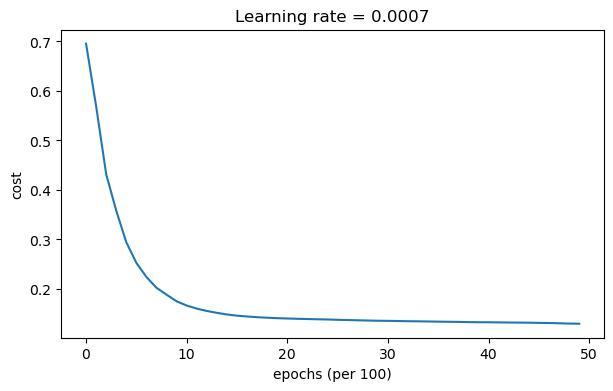

Accuracy: 94%


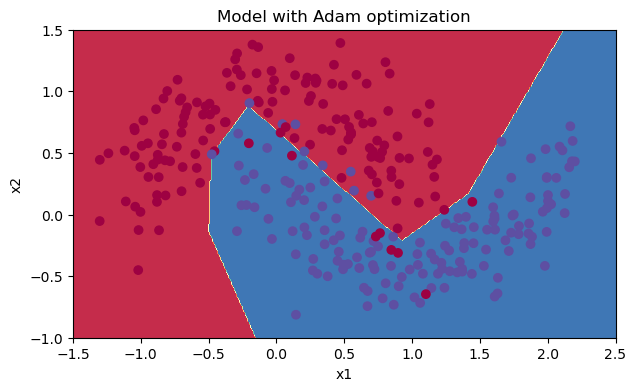

In [27]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

Adam clearly outperforms mini-batch gradient descent and Momentum. If we run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

## 7 - Learning Rate Decay and Scheduling

The learning rate is another hyperparameter that can help you speed up learning. During the first part of training, your model can get away with taking large steps, but over time, using a fixed value for the learning rate alpha can cause your model to get stuck in a wide oscillation that never quite converges. But if you were to slowly reduce your learning rate alpha over time, you could then take smaller, slower steps that bring you closer to the minimum (Learning rate decay can be achieved by using either adaptive methods or pre-defined learning rate schedules).

Lets implement the model including learning rate decay.

In [28]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=None, decay_rate=1):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    grads = {}           
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    m = X.shape[1]                   # number of training examples
    lr_rates = []
    learning_rate0 = learning_rate   # the original learning rate
    seed = 10                       
    
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            Al, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost and add to the cost total - we'll first accumulate costs over an entire epoch and then divide by the m training examples
            def compute_cost(Al, Y):

                logprobs = np.multiply(-np.log(Al),Y) + np.multiply(-np.log(1 - Al), 1 - Y)
                cost_total =  np.sum(logprobs)
                
                return cost_total
            
            cost_total += compute_cost(Al, minibatch_Y)

            # Backward propagation
            grads = L_model_backward(Al, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m

        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

We are going to use For this portion of the assignment, you'll try one of the pre-defined schedules for learning rate decay, called exponential learning rate decay. It takes this mathematical form:

$$\alpha = \frac{1}{1 + decayRate \times epochNumber} \alpha_{0}$$

In [29]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    learning_rate = 1 * learning_rate0 / (1+decay_rate*epoch_num)    

    return learning_rate

Cost after epoch 0: 0.695317
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.678419
learning rate after epoch 1000: 0.000100
Cost after epoch 2000: 0.676761
learning rate after epoch 2000: 0.000050
Cost after epoch 3000: 0.675745
learning rate after epoch 3000: 0.000033
Cost after epoch 4000: 0.675012
learning rate after epoch 4000: 0.000025


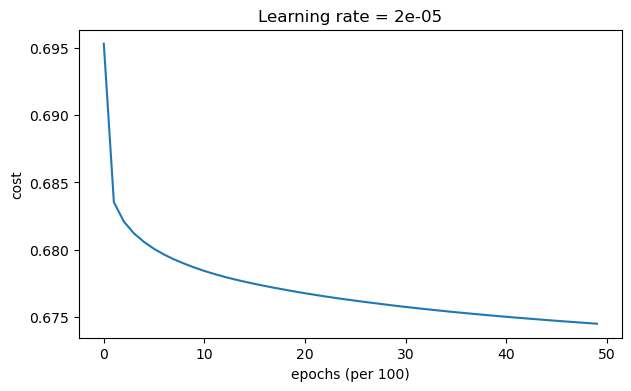

Accuracy: 64%


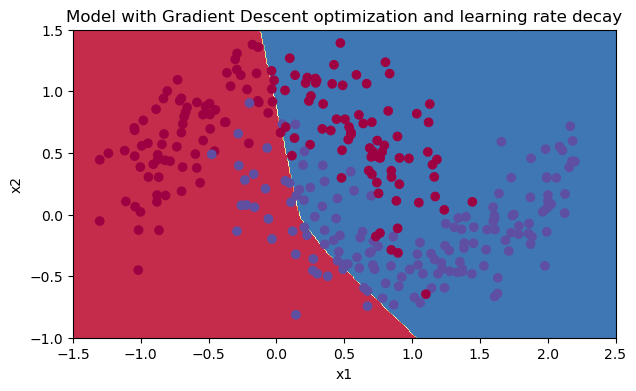

In [30]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')

# Plot decision boundary
plt.title("Model with Gradient Descent optimization and learning rate decay")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

Notice that if we set the decay to occur at every iteration, the learning rate goes to zero too quickly. One common fix to this issue is to decay the learning rate every few steps. This is called fixed interval scheduling.
$$\alpha = \frac{1}{1 + decayRate \times \lfloor\frac{epochNum}{timeInterval}\rfloor} \alpha_{0}$$

In [31]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    learning_rate = 1*learning_rate0/(1+decay_rate*np.floor(epoch_num/time_interval))

    return learning_rate

Now we are going to run the Learning Rate Decay with fixed interval scheduling for each Optimization Method

Cost after epoch 0: 0.695317
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.140077
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.136841
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.134102
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.135331
learning rate after epoch 4000: 0.020000


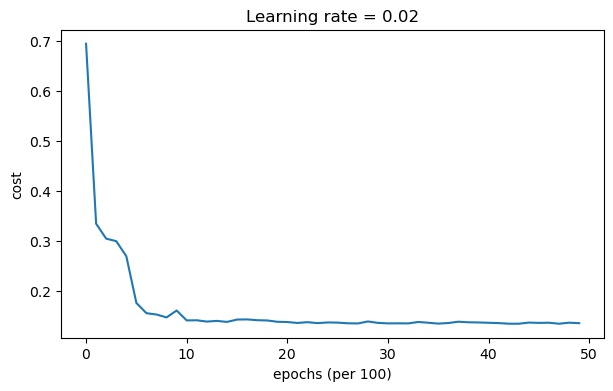

Accuracy: 93%


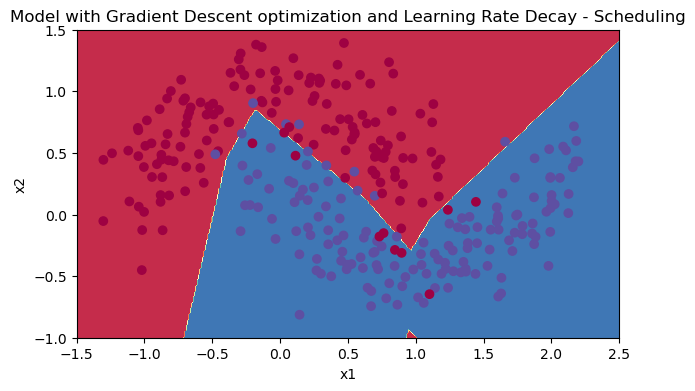

In [32]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')

# Plot decision boundary
plt.title("Model with Gradient Descent optimization and Learning Rate Decay - Scheduling")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.695582
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.137437
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.136119
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.135401
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.132711
learning rate after epoch 4000: 0.020000


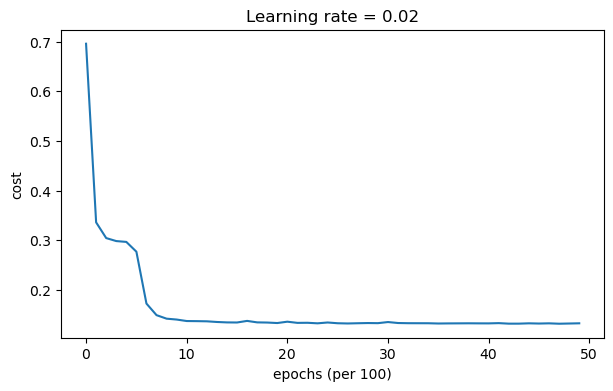

Accuracy: 93%


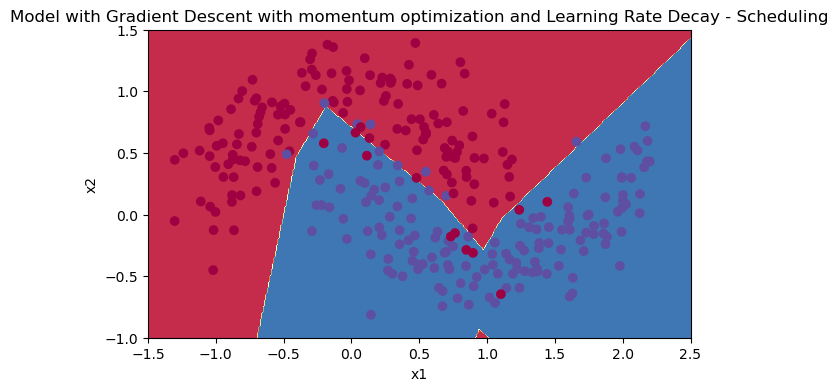

In [33]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "momentum", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')

# Plot decision boundary
plt.title("Model with Gradient Descent with momentum optimization and Learning Rate Decay - Scheduling")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.693414
learning rate after epoch 0: 0.010000
Cost after epoch 1000: 0.129544
learning rate after epoch 1000: 0.005000
Cost after epoch 2000: 0.129277
learning rate after epoch 2000: 0.003333
Cost after epoch 3000: 0.127801
learning rate after epoch 3000: 0.002500
Cost after epoch 4000: 0.127064
learning rate after epoch 4000: 0.002000


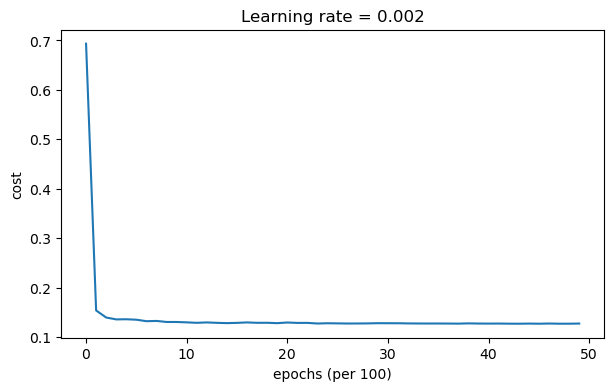

Accuracy: 94%


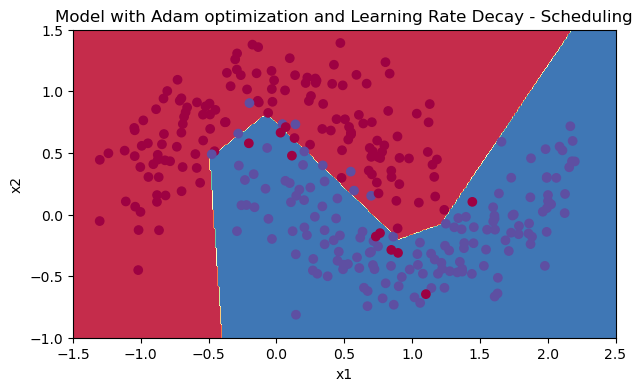

In [34]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam", learning_rate = 0.01, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions_train = predict(parameters, train_X)
print ('Accuracy: %d' % float((np.dot(train_Y, predictions_train.T) + np.dot(1 - train_Y, 1 - predictions_train.T)) / float(train_Y.size) *100) + '%')

# Plot decision boundary
plt.title("Model with Adam optimization and Learning Rate Decay - Scheduling")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

With Mini-batch GD or Mini-batch GD with Momentum, the accuracy is significantly lower than Adam, but when learning rate decay is added on top, either can achieve performance at a speed and accuracy score that's similar to Adam. In the case of Adam, the learning curve achieves a similar accuracy but faster.